In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Ucitavanje baze i njeno analiziranje:

In [2]:
data = pd.read_csv('diabetic_data.csv',na_values='*')
naziv_atributa = data.columns
#for col in naziv_atributa:
#    print(col)

In [3]:
data.shape

(101766, 50)

In [4]:
#da bih na jednom mestu imala koji su to sve kategoricki a koji su numericki atributi, radim sledece

numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
print('Numericki podaci su:\n')
for num in numerical_cols:
    print(num)
    
print('\n')
    
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
print('Kategoricki podaci su:\n')
for cat in categorical_cols:
    print(cat)

Numericki podaci su:

encounter_id
patient_nbr
admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses


Kategoricki podaci su:

race
gender
age
weight
payer_code
medical_specialty
diag_1
diag_2
diag_3
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


# Pretprocesiranje

In [5]:
#readmitted(ponovni prijem) - indikator da li je pacijent ponovo 
#primljen u bolnicu u roku od 30 dana nakon prvog prijema

#gledamo balansiranost podataka
broj_klasa = data['readmitted'].value_counts()
broj_klasa

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [6]:
#da bih imala 2 a ne tri klase radi lakseg rada(a i bolje tacnosti sto se
# kasnije pokazalo tako) spajam <30 i >30 klase u jednu
data['readmitted'] = data['readmitted'].replace({'>30': 're-admitted', '<30': 're-admitted'})

In [7]:
broj_klasa = data['readmitted'].value_counts()
broj_klasa

NO             54864
re-admitted    46902
Name: readmitted, dtype: int64

### Nedostajuce vrednosti

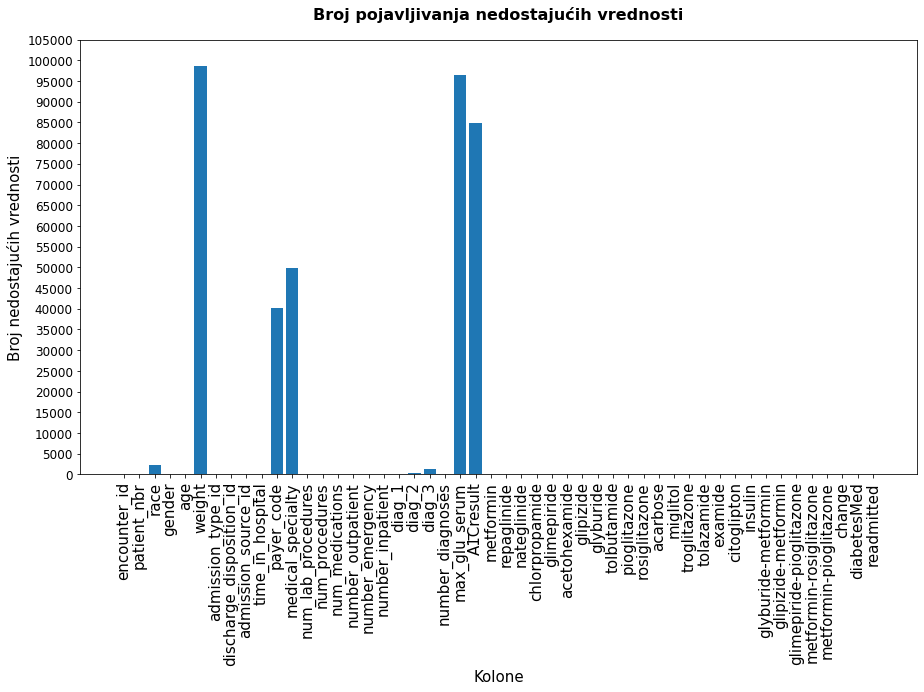

In [8]:
nedostajuce = data.isin(['?', 'None', 'nan']).sum()

plt.figure(figsize=(15, 8))
plt.bar(nedostajuce.index, nedostajuce.values)

plt.title('Broj pojavljivanja nedostajućih vrednosti', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Kolone',fontsize=15)
plt.ylabel('Broj nedostajućih vrednosti',fontsize=15)

plt.xticks(rotation=90,fontsize=15)
plt.yticks(np.arange(0, 110000,5000), fontsize=12)

plt.show()

In [9]:
#for x in categorical_cols:
#    print(data[x].unique())

In [10]:
upitnik = (data == '?').any(axis=0)
print(upitnik[upitnik])


race                 True
weight               True
payer_code           True
medical_specialty    True
diag_1               True
diag_2               True
diag_3               True
dtype: bool


In [11]:
none_vrednosti=(data =='None').any(axis=0)
print(none_vrednosti[none_vrednosti])

max_glu_serum    True
A1Cresult        True
dtype: bool


Po ovome smo jos jednom potvrdili da su atributi:race, weight, payer_code, medical_specialty, 
diag_1, diag_2 ,diag_3, max_glu_serum, A1Cresult  oni atributi koji koji imaju nedostajuce vrednosti.                     
Međutim, neki od ovih atributa mogu biti manje relevantni za ciljnu varijablu "readmitted", kao što su race, 
weight i payer_code(kod osiguravajuće kompanije), pa bi se mogli izostaviti iz skupa atributa. 
S druge strane, atributi diag_1(primarna dijagnoza), diag_2(sekundarna dijagnoza), diag_3(tercijarna dijagnoza),
max_glu_serum(najvisa izmerena glikemija) i A1Cresult(prosecna glikemija) mogu biti važni jer se tiču dijagnostike i tretmana dijabetesa,
što može biti povezano sa ponovnim prijemom u bolnicu.


In [12]:
# Popunjavanje nedostajućih vrednosti sa najčešćom vrednošću u koloni(jer su ovi "bitni" atributi relevantni
# i vazni za nasu bazu i za razmatranje ponovnog prijema u bolnicu)

bitni=['diag_1', 'diag_2', 'diag_3', 'max_glu_serum' ,'A1Cresult']


for b in bitni:
    most_frequent_value = data[b].mode().values[0]
    data[b] = data[b].replace(['?', 'None'], most_frequent_value)

In [13]:
data.drop(['race','weight','payer_code','medical_specialty','encounter_id','patient_nbr', 'examide', 'citoglipton'], axis=1,inplace=True)
# 'examide', 'citoglipton'- obrisani jer imaju samo vrednost 'No'

In [14]:
#kategoricki atributi posle brisanja pojedinih:
categorical_cols2 = data.select_dtypes(include=['object', 'category']).columns
print('Kategoricki podaci su:\n')
for cat in categorical_cols2:
    print(cat)

Kategoricki podaci su:

gender
age
diag_1
diag_2
diag_3
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


### Konvertovanje kategorickih podataka u numericke radi lakseg rada nad podacima
OneHotEncoder je pravio veci problem od LabelEncodera, zbog mnogo duzeg rada na podacima i malo gore tacnosti

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for c in categorical_cols2:
    data[c] = label_encoder.fit_transform(data[c])

In [16]:
data.describe()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,0.462443,6.096702,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,...,0.000393,1.405469,1.006898,0.000128,0.000010,0.000020,0.000010,0.538048,0.770031,0.460881
std,0.498649,1.594084,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,...,0.020312,0.838798,0.084414,0.011302,0.003135,0.004433,0.003135,0.498553,0.420815,0.498470
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,6.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,7.000000,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,...,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,2.000000,9.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,...,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
data.head()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0,0,6,25,1,1,41,0,1,0,...,0,1,1,0,0,0,0,1,0,0
1,0,1,1,1,7,3,59,0,18,0,...,0,3,1,0,0,0,0,0,1,1
2,0,2,1,1,7,2,11,5,13,2,...,0,1,1,0,0,0,0,1,1,0
3,1,3,1,1,7,2,44,1,16,0,...,0,3,1,0,0,0,0,0,1,0
4,1,4,1,1,7,1,51,0,8,0,...,0,2,1,0,0,0,0,0,1,0


### Podela na  na ulazne atribute (X) i ciljnu promenljivu (y).


In [18]:
X = data.drop(['readmitted'], axis=1)
y = data['readmitted']
print(X.shape,y.shape)

(101766, 41) (101766,)


### Rad sa outlier-ima preko IQR-a i boxplot-ovanje i kasnije brisanje outlier-a

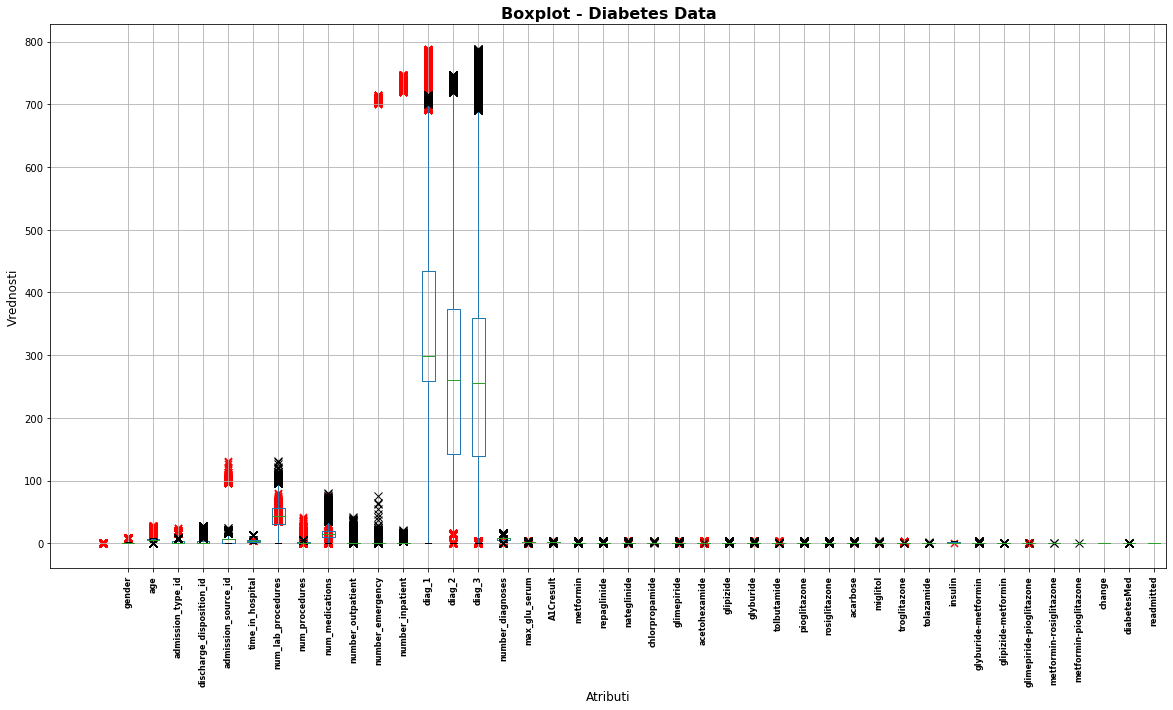

In [19]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, va='top', fontsize=7, fontweight='bold')
data.boxplot(showfliers=True, flierprops=dict(marker='x', markerfacecolor='blue', markersize=8))

# Podešavanje naslova i oznaka osa
plt.title('Boxplot - Diabetes Data', fontsize=16, fontweight='bold')
plt.xlabel('Atributi', fontsize=12)
plt.ylabel('Vrednosti', fontsize=12)
plt.xticks(rotation='vertical', fontsize=8)


# Prikazivanje IQR raspona
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Prikazivanje vrednosti outliera
for col in data.columns:
    outliers = ((data[col] < lower_bound[col]) | (data[col] > upper_bound[col]))
    if outliers.any():
        x = [col] * outliers.sum()
        yy = data.loc[outliers, col]
        plt.scatter(x, yy, c='red', marker='x', s=50)

# Prikazivanje boxplot-a
plt.show()

In [20]:
data=data[~outliers]
#brisanje outlier-a

### Graficki prikaz korelisanosti izmedju atributa
Kao sto mozemo videti na grafikonu, korelisanost izmedju atributa skoro pa i da ne postoji, sto znaci da preko 
matrice korelacije ne mozemo da vidimo koje bismo atribute jos mogli eventualno da obrisemo

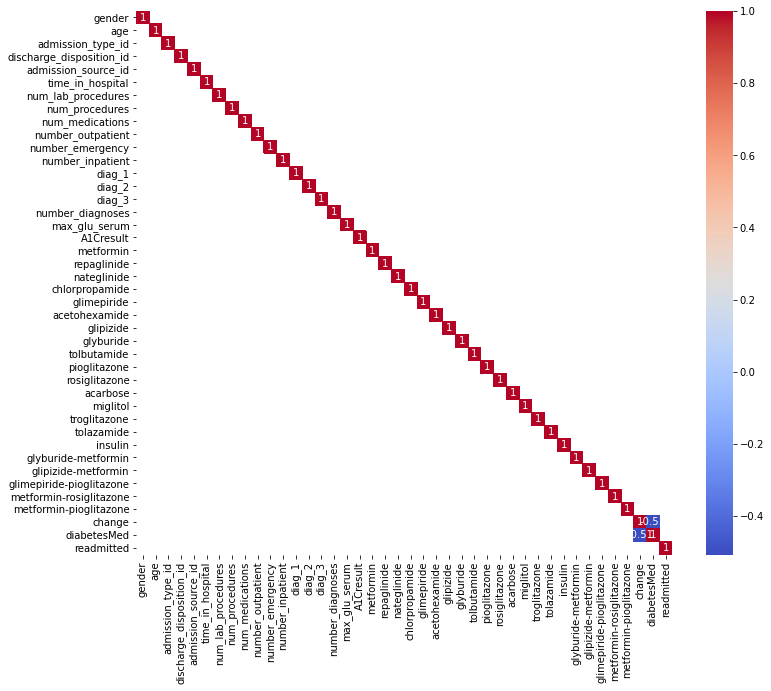

In [21]:
import seaborn as sns

matrica_korelacije = data.corr()

prag = 0.5

korelisani = matrica_korelacije.abs() > prag
korelisani_matrica = matrica_korelacije[korelisani]

plt.figure(figsize=(12, 10))

sns.heatmap(korelisani_matrica, annot=True, cmap='coolwarm')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


### Feature selection

In [22]:
from sklearn.feature_selection import SelectKBest, chi2

k = 25  
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support(indices=True)]

print(selected_features)


Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'metformin', 'glipizide', 'tolbutamide',
       'tolazamide', 'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'change', 'diabetesMed'],
      dtype='object')


In [23]:
selected_features = ['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'metformin', 'glipizide', 'tolbutamide',
       'tolazamide', 'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'change', 'diabetesMed']

#brisanje ostalih atributa koji su po feature selection-u manje bitni
data = data.drop(columns=data.columns.difference(selected_features))

In [24]:
data.shape

(101766, 25)

# Pripema podataka za klasifikaciju - podela na trening i test skupove:

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

Normalizacija podataka 

In [27]:
normalizer = Normalizer()
scaler = StandardScaler()

In [28]:
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

### PCA algoritam

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA(n_components=3)
pca.fit(X_train_normalized)

PCA(n_components=3)

In [31]:
pca.components_.shape

(3, 41)

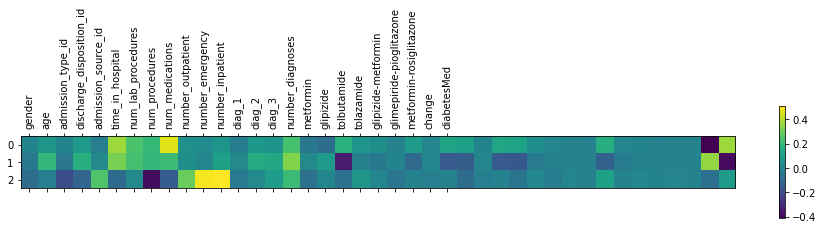

In [32]:
selected_data = data[selected_features]


pca_names = [f'{i}' for i in range(pca.n_components_)]

# Prikaz matrice komponenata PCA
plt.matshow(pca.components_)
plt.xticks(ticks=range(len(selected_features)), labels=selected_features, rotation='vertical')
plt.yticks(ticks=range(pca.n_components_), labels=pca_names)
plt.colorbar()
plt.show()

In [33]:
pca.explained_variance_

array([2.37435858, 1.90202579, 1.45251292])

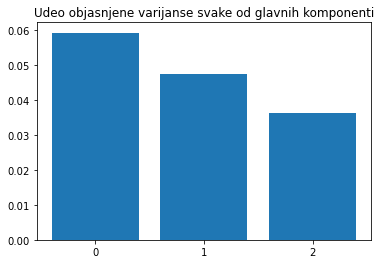

In [34]:
plt.bar(x=pca_names,
        height=pca.explained_variance_ratio_)
plt.title('Udeo objasnjene varijanse svake od glavnih komponenti')
plt.show()

In [35]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

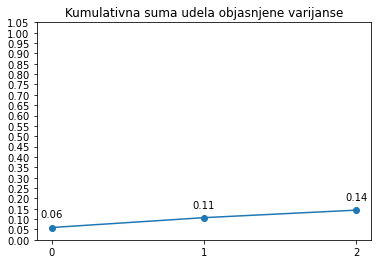

In [36]:
plt.plot(pca_names, cumulative_variance_ratio, marker='o')
plt.title('Kumulativna suma udela objasnjene varijanse')
plt.yticks(np.arange(0, 1.1, 0.05))
for i, j in zip(pca_names, cumulative_variance_ratio):
    plt.annotate(f'{j:.2f}', (i, j), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [40]:
X_train_pca = pca.transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

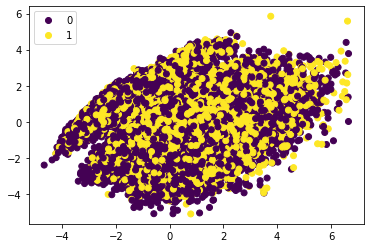

In [41]:
class_names=y
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names.tolist())
plt.show()

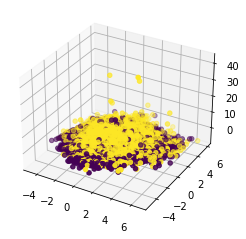

In [42]:
from mpl_toolkits.mplot3d import Axes3D

scatter = plt.figure().add_subplot(111, projection='3d')
scatter.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train)

plt.show()


## Primena prvog algoritma - Stablo odlucivanja


### GridSearch

Pretraživanje različitih kombinacija hiperparametara modela kako bi se pronašla najbolja kombinacija koja daje najbolje rezultate.

In [43]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [10, 15, 20]
}


In [44]:
gs = GridSearchCV(DecisionTreeClassifier(),
             param_grid=param_grid_tree,
             scoring='accuracy',
             cv=4,
             verbose=5)

In [45]:
gs.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV 1/4] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.567 total time=   0.9s
[CV 2/4] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.568 total time=   0.8s
[CV 3/4] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.571 total time=   0.9s
[CV 4/4] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.563 total time=   0.9s
[CV 1/4] END criterion=gini, max_depth=None, min_samples_split=15;, score=0.573 total time=   0.8s
[CV 2/4] END criterion=gini, max_depth=None, min_samples_split=15;, score=0.569 total time=   0.8s
[CV 3/4] END criterion=gini, max_depth=None, min_samples_split=15;, score=0.575 total time=   0.8s
[CV 4/4] END criterion=gini, max_depth=None, min_samples_split=15;, score=0.563 total time=   0.8s
[CV 1/4] END criterion=gini, max_depth=None, min_samples_split=20;, score=0.574 total time=   0.8s
[CV 2/4] END criterion=gini, max_depth=None, min

[CV 4/4] END criterion=entropy, max_depth=10, min_samples_split=20;, score=0.628 total time=   0.5s
[CV 1/4] END criterion=entropy, max_depth=20, min_samples_split=10;, score=0.585 total time=   0.8s
[CV 2/4] END criterion=entropy, max_depth=20, min_samples_split=10;, score=0.589 total time=   0.9s
[CV 3/4] END criterion=entropy, max_depth=20, min_samples_split=10;, score=0.588 total time=   0.8s
[CV 4/4] END criterion=entropy, max_depth=20, min_samples_split=10;, score=0.582 total time=   1.0s
[CV 1/4] END criterion=entropy, max_depth=20, min_samples_split=15;, score=0.586 total time=   0.8s
[CV 2/4] END criterion=entropy, max_depth=20, min_samples_split=15;, score=0.588 total time=   0.8s
[CV 3/4] END criterion=entropy, max_depth=20, min_samples_split=15;, score=0.588 total time=   0.8s
[CV 4/4] END criterion=entropy, max_depth=20, min_samples_split=15;, score=0.582 total time=   0.8s
[CV 1/4] END criterion=entropy, max_depth=20, min_samples_split=20;, score=0.587 total time=   0.8s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_split': [10, 15, 20]},
             scoring='accuracy', verbose=5)

In [46]:
print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10)
0.6288262172652681
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}


### Moj izbor

In [51]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10)

In [52]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10)

In [54]:
y_pred = model.predict(X_test)

In [55]:
confusion_matrix(y_test,y_pred)

array([[8098, 2875],
       [5277, 4104]])

In [56]:
a1=accuracy_score(y_test, y_pred)
a1

0.5994890439225705

## Primena drugog algoritma - RandomForestClassifier(slucajne sume)

### GridSearch

In [53]:
param_grid_forest = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 5, 10],  
    'min_samples_split': [10, 15, 20], 
}

gss = GridSearchCV(RandomForestClassifier(),
             param_grid=param_grid_forest,
             scoring='accuracy',
             cv=4,
             verbose=5)


In [54]:
gss.fit(X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END max_depth=None, min_samples_split=10, n_estimators=100;, score=0.640 total time=   6.7s
[CV 2/4] END max_depth=None, min_samples_split=10, n_estimators=100;, score=0.632 total time=   6.6s
[CV 3/4] END max_depth=None, min_samples_split=10, n_estimators=100;, score=0.642 total time=   6.8s
[CV 4/4] END max_depth=None, min_samples_split=10, n_estimators=100;, score=0.640 total time=   6.6s
[CV 1/4] END max_depth=None, min_samples_split=10, n_estimators=200;, score=0.639 total time=  13.7s
[CV 2/4] END max_depth=None, min_samples_split=10, n_estimators=200;, score=0.636 total time=  13.3s
[CV 3/4] END max_depth=None, min_samples_split=10, n_estimators=200;, score=0.643 total time=  13.4s
[CV 4/4] END max_depth=None, min_samples_split=10, n_estimators=200;, score=0.641 total time=  13.7s
[CV 1/4] END max_depth=None, min_samples_split=10, n_estimators=300;, score=0.640 total time=  20.5s
[CV 2/4] END max_depth=None, 

[CV 3/4] END max_depth=10, min_samples_split=10, n_estimators=300;, score=0.641 total time=  10.1s
[CV 4/4] END max_depth=10, min_samples_split=10, n_estimators=300;, score=0.639 total time=  10.2s
[CV 1/4] END max_depth=10, min_samples_split=15, n_estimators=100;, score=0.637 total time=   3.3s
[CV 2/4] END max_depth=10, min_samples_split=15, n_estimators=100;, score=0.633 total time=   3.3s
[CV 3/4] END max_depth=10, min_samples_split=15, n_estimators=100;, score=0.642 total time=   3.3s
[CV 4/4] END max_depth=10, min_samples_split=15, n_estimators=100;, score=0.639 total time=   3.5s
[CV 1/4] END max_depth=10, min_samples_split=15, n_estimators=200;, score=0.636 total time=   6.7s
[CV 2/4] END max_depth=10, min_samples_split=15, n_estimators=200;, score=0.632 total time=   6.6s
[CV 3/4] END max_depth=10, min_samples_split=15, n_estimators=200;, score=0.642 total time=   6.8s
[CV 4/4] END max_depth=10, min_samples_split=15, n_estimators=200;, score=0.640 total time=   7.0s
[CV 1/4] E

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=5)

In [55]:
print(gss.best_estimator_)
print(gss.best_score_)
print(gss.best_params_)

RandomForestClassifier(min_samples_split=15, n_estimators=300)
0.6432221294158109
{'max_depth': None, 'min_samples_split': 15, 'n_estimators': 300}


### Moj izbor

In [59]:
#model2 = RandomForestClassifier()

In [81]:
model2= RandomForestClassifier(max_depth=None,min_samples_split=15, n_estimators=300)

In [83]:
model2.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=15, n_estimators=300)

In [84]:
y_pred2 = model2.predict(X_test)

In [85]:
confusion_matrix(y_test,y_pred2)

array([[8150, 2823],
       [4471, 4910]], dtype=int64)

In [86]:
a2=accuracy_score(y_test, y_pred2)
a2

0.6416429203105041

## Primena treceg algoritma - GradientBoostingClassifier

### GridSearch

In [65]:
param_grid_gradient = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}


gsss = GridSearchCV(GradientBoostingClassifier(),
             param_grid=param_grid_gradient,
             scoring='accuracy',
             cv=4,
             verbose=5)


In [66]:
gsss.fit(X_train, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV 1/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.636 total time=   7.9s
[CV 2/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.636 total time=   8.1s
[CV 3/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.643 total time=   7.9s
[CV 4/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.639 total time=   8.0s
[CV 1/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.644 total time=  16.2s
[CV 2/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.640 total time=  16.2s
[CV 3/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.648 total time=  16.4s
[CV 4/4] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.642 total time=  15.9s
[CV 1/4] E

[CV 4/4] END learning_rate=0.1, max_depth=5, min_samples_split=6, n_estimators=300;, score=0.643 total time=  38.3s
[CV 1/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.648 total time=  18.0s
[CV 2/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.643 total time=  17.8s
[CV 3/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.647 total time=  17.9s
[CV 4/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.642 total time=  17.7s
[CV 1/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_estimators=200;, score=0.645 total time=  35.8s
[CV 2/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_estimators=200;, score=0.643 total time=  35.6s
[CV 3/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_estimators=200;, score=0.646 total time=  35.9s
[CV 4/4] END learning_rate=0.1, max_depth=7, min_samples_split=2, n_esti

[CV 3/4] END learning_rate=0.05, max_depth=3, min_samples_split=6, n_estimators=300;, score=0.647 total time=  24.8s
[CV 4/4] END learning_rate=0.05, max_depth=3, min_samples_split=6, n_estimators=300;, score=0.642 total time=  24.3s
[CV 1/4] END learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.640 total time=  13.2s
[CV 2/4] END learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.637 total time=  12.8s
[CV 3/4] END learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.643 total time=  13.0s
[CV 4/4] END learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.642 total time=  12.8s
[CV 1/4] END learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.646 total time=  26.4s
[CV 2/4] END learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.642 total time=  26.2s
[CV 3/4] END learning_rate=0.05, max_depth=5, min_samples_split=

[CV 2/4] END learning_rate=0.05, max_depth=7, min_samples_split=6, n_estimators=300;, score=0.644 total time=  53.4s
[CV 3/4] END learning_rate=0.05, max_depth=7, min_samples_split=6, n_estimators=300;, score=0.647 total time=  53.5s
[CV 4/4] END learning_rate=0.05, max_depth=7, min_samples_split=6, n_estimators=300;, score=0.644 total time=  53.2s
[CV 1/4] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.618 total time=   7.9s
[CV 2/4] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.615 total time=   7.9s
[CV 3/4] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.622 total time=   7.9s
[CV 4/4] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=100;, score=0.623 total time=   8.2s
[CV 1/4] END learning_rate=0.01, max_depth=3, min_samples_split=2, n_estimators=200;, score=0.626 total time=  15.9s
[CV 2/4] END learning_rate=0.01, max_depth=3, min_samples_split=

[CV 1/4] END learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300;, score=0.637 total time=  38.3s
[CV 2/4] END learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300;, score=0.631 total time=  38.0s
[CV 3/4] END learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300;, score=0.639 total time=  38.4s
[CV 4/4] END learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300;, score=0.638 total time=  38.1s
[CV 1/4] END learning_rate=0.01, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.633 total time=  17.8s
[CV 2/4] END learning_rate=0.01, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.628 total time=  17.7s
[CV 3/4] END learning_rate=0.01, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.634 total time=  17.8s
[CV 4/4] END learning_rate=0.01, max_depth=7, min_samples_split=2, n_estimators=100;, score=0.633 total time=  17.7s
[CV 1/4] END learning_rate=0.01, max_depth=7, min_samples_split=

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=5)

In [67]:
print(gsss.best_estimator_)
print(gsss.best_score_)
print(gsss.best_params_)

GradientBoostingClassifier(max_depth=5, n_estimators=300)
0.6483073748341768
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}


### Moj izbor

In [ ]:
#model3 = GradientBoostingClassifier()

In [76]:
model3=GradientBoostingClassifier(learning_rate=0.1,max_depth=5,min_samples_split=2, n_estimators=300)

In [77]:
model3.fit(X_train_normalized,y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=300)

In [78]:
y_pred3 = model3.predict(X_test_normalized)

In [79]:
confusion_matrix(y_test,y_pred3)

array([[8094, 2879],
       [4199, 5182]], dtype=int64)

In [80]:
a3=accuracy_score(y_test, y_pred3)
a3

0.6522550849955783

## Accuracy za sva tri modela

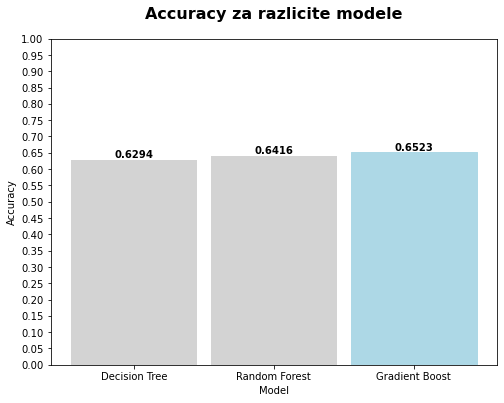

In [89]:
modeli = ['Decision Tree', 'Random Forest', 'Gradient Boost']

accuracy_scores = [a1,a2,a3]
plt.figure(figsize=(8, 6))
bars = plt.bar(modeli, accuracy_scores, width=0.9, color=['lightgray', 'lightgray', 'lightgray'])

#plt.bar(modeli, accuracy_scores,width=0.9,color='lightgray')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy za razlicite modele',fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1])  
plt.yticks([i/100 for i in range(0, 101, 5)])
max_index = accuracy_scores.index(max(accuracy_scores))
bars[max_index].set_color('lightblue')
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', color='black', fontweight='bold')

plt.show()

## Poredjenje modela preko ROC krive

C:\Users\raden\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\raden\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\raden\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\rad

Text(0, 0.5, 'Tačno pozitivna stopa (TPR)')

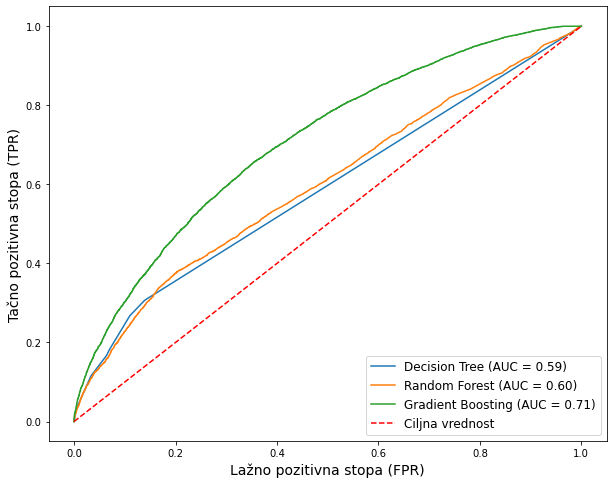

In [75]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(10, 8))

plot_roc_curve(model, X_test_normalized, y_test, ax=ax, name='Decision Tree')
plot_roc_curve(model2, X_test_normalized, y_test, ax=ax, name='Random Forest')
plot_roc_curve(model3, X_test_normalized, y_test, ax=ax, name='Gradient Boosting')
fpr = np.linspace(0, 1, 100)
tpr = fpr
plt.plot(fpr, tpr, linestyle='--', color='red', label='Ciljna vrednost')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Lažno pozitivna stopa (FPR)', fontsize=14)
plt.ylabel('Tačno pozitivna stopa (TPR)', fontsize=14)
